# Data Analysis and Model Selection

In [23]:
# Dependencies and packages
%reload_ext lab_black
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ sci-kit learn ------------------#
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ----------------- joblib dump & load --------------#
from joblib import dump
from joblib import load

## Exploratory Data Analysis

In [3]:
fish_data = pd.read_csv(os.path.join("../data/fish_participant.csv"))
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
1,Perch,110.0,20.0,22.0,23.5,5.5225,3.9950
2,Roach,160.0,20.5,22.5,25.3,7.0334,3.8203
3,Parkki,60.0,14.3,15.5,17.4,6.5772,2.3142
4,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854


In [4]:
# check the df for all required stats
fish_data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,401.676577,26.447748,28.615315,31.422523,9.015701,4.480407
std,338.510755,9.795155,10.498781,11.306311,4.225369,1.696240
min,5.900000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,142.500000,20.000000,22.000000,23.500000,6.138850,3.551400
50%,300.000000,25.400000,27.500000,30.100000,8.145400,4.335000
75%,682.500000,33.750000,36.250000,40.150000,12.143400,5.658300
max,1550.000000,56.000000,60.000000,64.000000,18.957000,8.142000


In [5]:
# data types
fish_data.dtypes

Species     object
Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64
dtype: object

In [6]:
# check for missing values
fish_data.apply(lambda x: x.isnull().value_counts())

,Species,Weight,Length1,Length2,Length3,Height,Width
False,111,111,111,111,111,111,111


In [7]:
fish_data.Species.value_counts()

Perch        39
Bream        24
Roach        14
Pike         12
Smelt        10
Parkki        8
Whitefish     4
Name: Species, dtype: int64

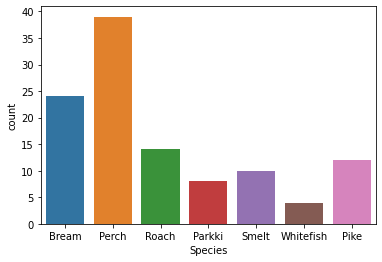

In [8]:
# Plot the species count
sns.countplot(data=fish_data, x="Species")

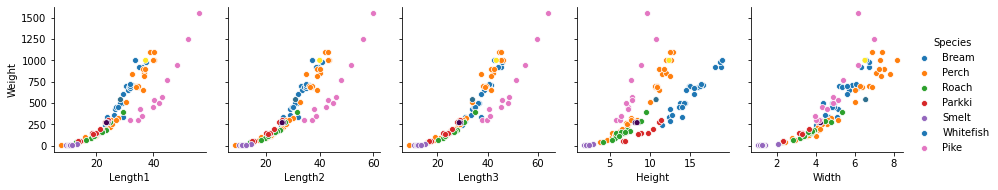

In [9]:
sns.pairplot(
    data=fish_data,
    x_vars=["Length1", "Length2", "Length3", "Height", "Width"],
    y_vars="Weight",
    hue="Species",
)

Dependent variable-'weight' has linear relationship with all other variables

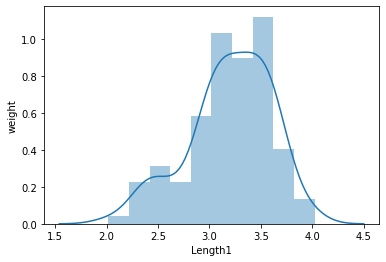

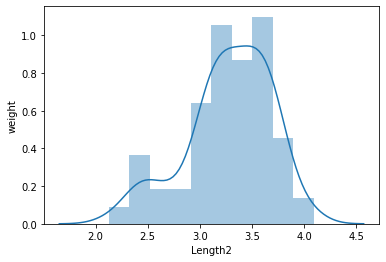

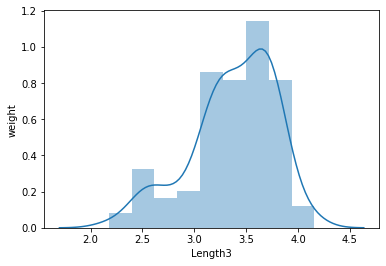

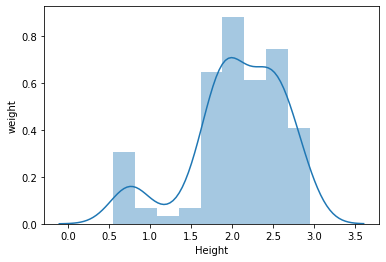

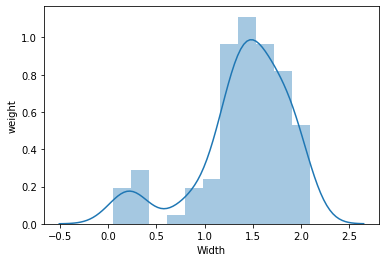

In [14]:
# Checking the linear relationships and distributions

numerical = ["Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:
    fig = sns.distplot(np.log(fish_data[feature]))
    fig.set_ylabel("weight")
    fig.set_xlabel(feature)
    plt.show()

## Load train and test data

In [16]:
# train data
train_path = os.path.join("../data/fish_participant.csv")
train_df = pd.read_csv(train_path)
# test data
test_path = os.path.join("../data/fish_holdout_demo.csv")
test_df = pd.read_csv(test_path)

In [17]:
X_train = train_df[["Height", "Width", "Length3", "Length2"]].values
y_train = train_df["Weight"].values

In [18]:
X_test = test_df[["Height", "Width", "Length3", "Length2"]].values
y_test = test_df["Weight"].values

## Gradient Boosting For Regression

### [scikit-learn Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Gradient boosting Regression calculates the difference between the current prediction and the known correct target value.
This difference is called residual. After that Gradient boosting Regression trains a weak model that maps features to that residual. This residual predicted by a weak model is added to the existing model input and thus this process nudges the model towards the correct target. Repeating this step again and again improves the overall model prediction.

In [5]:
gbreg = GradientBoostingRegressor()
gbreg.fit(X_train, y_train)

GradientBoostingRegressor()

In [6]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in gbreg.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)
best_n_estimators

98

In [7]:
gbreg = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    max_depth=6,
    min_samples_split=2,
    learning_rate=0.1,
    loss="ls",
)
gbreg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=6, n_estimators=98)

In [8]:
print("Feature Importances")
print(gbreg.feature_importances_)

Feature Importances
[0.00932101 0.75134359 0.22141666 0.01791873]


In [9]:
y_pred = gbreg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print("MSE for GBR:", MSE)
# r^2: R-squared is the proportion of variance explained
print("r-squared score for Train: %.2f" % gbreg.score(X_train, y_train))
print("r-squared score for Test: %.2f" % gbreg.score(X_test, y_test)) 

MSE for GBR: 0.006705249820909959
r-squared score for Train: 1.00
r-squared score for Test: 1.00


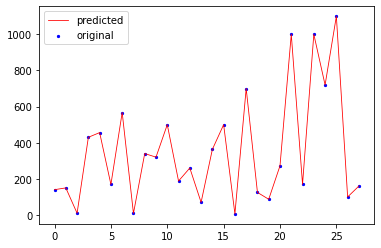

In [10]:
# plot
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [11]:
y_pred1 = pd.DataFrame(y_pred, columns=["Estimated Weight"])
y_pred1.head()

,Estimated Weight
0,140.088574
1,149.909963
2,9.855603
3,430.060427
4,455.967250


In [12]:
y_test1 = pd.DataFrame(y_test)
y_test1 = y_test1.reset_index(drop=True)
y_test1.head()

,0
0,140.0
1,150.0
2,9.8
3,430.0
4,456.0


In [13]:
y_new = pd.concat([y_test1, y_pred1], axis=1)
y_new

,0,Estimated Weight
0,140.0,140.088574
1,150.0,149.909963
2,9.8,9.855603
3,430.0,430.060427
4,456.0,455.967250
5,169.0,169.101166
6,567.0,566.930958
7,8.7,8.760698
8,340.0,340.094366
9,320.0,320.058740


## Linear Regression

In [19]:
# Fitting LR to the Training Set
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
# predict value
y_pred = lr.predict(X_test)
y_pred

array([ 201.78238937,  200.41770177, -169.87620467,  555.05855161,
        619.75971191,  236.72059535,  730.66228676, -188.32718849,
        539.89877521,  439.93178301,  514.85106451,  289.02503498,
        370.07745752,   63.90633176,  453.52046565,  512.29569122,
       -209.77127395,  584.80343775,  176.39720488,  105.58435508,
        342.56247063,  762.94548833,  243.38613883,  877.63809364,
        689.08417508,  854.43037206,  102.25200577,  197.79488569])

In [24]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("MSE for LR:", mse)
print("RMSE for LR:", rmse)
print("R2_Score for LR:", r2)

MSE for LR: 15841.309581365576
RMSE for LR: 125.86226432638806
R2_Score for LR: 0.8303448464398903
